In [7]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.patches import Ellipse
import math
#for removing warnings
import warnings

In [2]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [3]:
ds = open_s3fs('PC-data')
ds

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [4]:
# Smoothen data, over every tenth point in both x and y direction, for all the data
vvar = ds.vomecrty.isel(y=slice(900,1800), x=slice(200,1400))
uvar = ds.vozocrtx.isel(y=slice(900,1800), x=slice(200,1400))
uv = ds.vel.isel(y=slice(900,1800), x=slice(200,1400))

In [5]:
# chooseing a level to look at 
level_list = [0, 7, 14, 20, 35, 50, 60]
depth_list = np.zeros(7)
for i, level in enumerate(level_list):
    depth = ds.depth[level].values
    depth_list[i] = depth
print(depth_list)

[5.05760014e-01 9.82275009e+00 3.08745613e+01 6.90216827e+01
 3.33862823e+02 1.51636365e+03 3.13856494e+03]


In [6]:
'A funcktion for constructing PC ellipses at a given level '
def pc_ellipse(level):
    
    dx = 20
    dy = 20
    jmax, imax = uv[0].shape
    i_list = np.arange(0,imax,dx)
    j_list = np.arange(0,jmax,dy)

    y = []
    x = []
    
    #ellipser:
    theta_l = []
    minor_l = []
    major_l = []

    indx =0
    
    # to get the loop to run faster
    uvy = np.array(uv.y.values)
    uvx = np.array(uv.x.values)
    
    # fetching the varaibel at the given level 
    uvar_depth = np.array(uvar[level,:,:].values)
    vvar_depth = np.array(vvar[level,:,:].values)
    uv_depth = np.array(uv[level,:,:].values)

    for i in i_list:
        for j in j_list:
            covm = np.array([[uvar_depth[j,i],uv_depth[j,i]],
                [uv_depth[j,i],vvar_depth[j,i]]],dtype=float)
            if np.isnan(covm).any():
                continue
            else:
                # Find and sort eigenvalues and eigenvectors into descending order
                values, vectors = np.linalg.eig(covm)
                order = values.argsort()[::-1]
                values, vectors = values[order], vectors[:, order]

                # center of ellipse
                y.append(uvy[j])
                x.append(uvx[i])

                # ellipser :
                major = np.sqrt(values[0])*1e3
                minor = np.sqrt(values[1])*1e3

                major_l.append(major)
                minor_l.append(minor)

                # The anti-clockwise angle to rotate our ellipse by 
                vx, vy = vectors[:,0][0], vectors[:,0][1]
                theta = np.arctan2(vy, vx)*(180/math.pi)
                theta_l.append(theta)

                indx = indx + 1

    # converting to np.arrays
    y = np.array(y,dtype=float)
    x = np.array(x,dtype=float)
   
    return major_l, minor_l, theta_l, x, y

In [6]:
'A funcktion for constructing PC at a given level '
def PC_funk(level):
    warnings.filterwarnings('ignore')
    
    dx = 20
    dy = 20
    # Making empty list with size as data-points 
    jmax, imax = uv[0].shape #fetches the max value in j and i direction 
    i_list = np.arange(0,imax,dx)
    j_list = np.arange(0,jmax,dy)
    
    # Making the covmatrix and finding the eigenvalues and eigenvectors
    # list of all the points for the PC-crosses
    PC11 = []
    PC12 = []
    PC21 = []
    PC22 = []
    y = []
    x = []
    indx = 0
    
    # to get the loop to run faster
    uvy = np.array(uv.y.values)
    uvx = np.array(uv.x.values)
    
    # fetching the varaibel at the given level 
    uvar_depth = np.array(uvar[level,:,:].values)
    vvar_depth = np.array(vvar[level,:,:].values)
    uv_depth = np.array(uv[level,:,:].values)
    
    for i in i_list:
        for j in j_list:
            covm = np.array([[uvar_depth[j,i],uv_depth[j,i]],
            [uv_depth[j,i],vvar_depth[j,i]]],dtype=float)
            if np.isnan(covm).any():
                continue
            else:
                values, vectors = np.linalg.eig(covm)
                PC11.append(vectors[0,0]*np.sqrt(values[0]))
                PC12.append(vectors[1,0]*np.sqrt(values[0]))
                PC21.append(vectors[0,1]*np.sqrt(values[1]))
                PC22.append(vectors[1,1]*np.sqrt(values[1]))
                y.append(uvy[j])
                x.append(uvx[i])
                indx = indx + 1
                
    # converting to np.arrays
    PC11 = np.array(PC11,dtype=float)
    PC12 = np.array(PC12,dtype=float)
    PC21 = np.array(PC21,dtype=float)
    PC22 = np.array(PC22,dtype=float)
    y = np.array(y,dtype=float)
    x = np.array(x,dtype=float)
    
    
    return PC11, PC12, PC21, PC22, x, y 

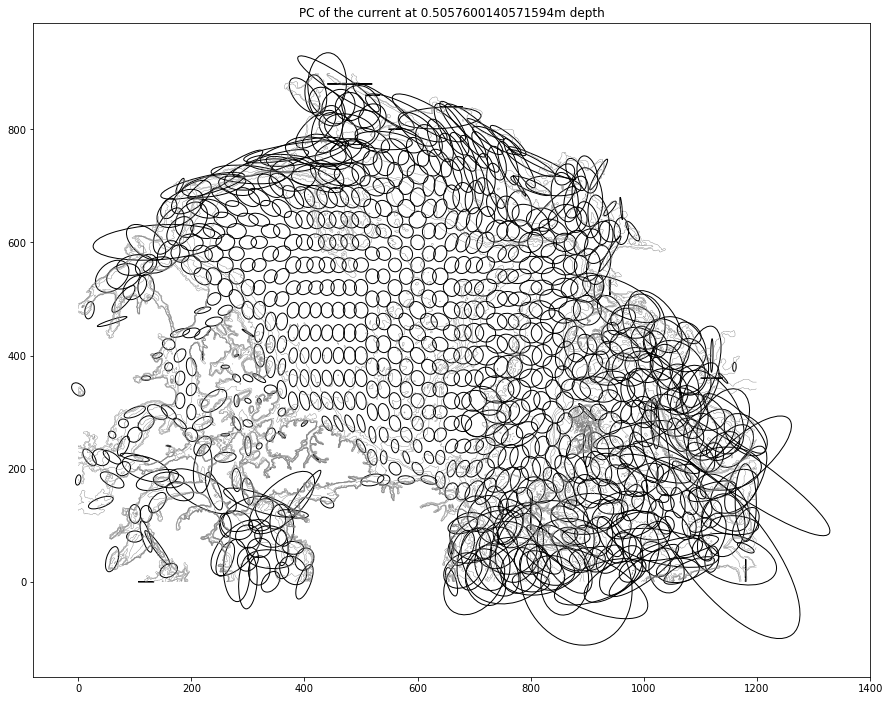

In [12]:
# Plot level 1
n = 0
maj_ax, min_ax, angel, x, y = pc_ellipse(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
ax.contour(ds.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)

for i in range(int(len(x)/2)):
    ellipse = Ellipse((x[i*2],y[i*2]), 
                      width = maj_ax[i*2]*2, 
                      height = min_ax[i*2]*2,
                      angle = angel[i*2],
                      facecolor = 'none',
                      edgecolor='k')
    ax.add_patch(ellipse)

ax.set_aspect('equal')
plt.show()

Figure of the PC at depth 0.5m depth. The PC crosses on the shelf are mostly an-isotrop, but still not alligned with the topography. The crosses are only allingned with the topography close to the boundaries. 
In the ocean basin the crosses are more ispotrope. The largest varaince can be found in Fram strait, but alos Bering stait and the Barents sea have larger variance. 

Figure of the PC at a depth of 0.5m. The PC crosses on the shelf are largely an-isotrope, tho they are not aligned with the topography.
Only the terrain adjacent to the boundaries is alligned with the crosses.
Crosses are more ispotrope in the ocean basin.
The most variation may be found in the Fram Strait, but the Bering Strait and the Barents Sea also have more. 

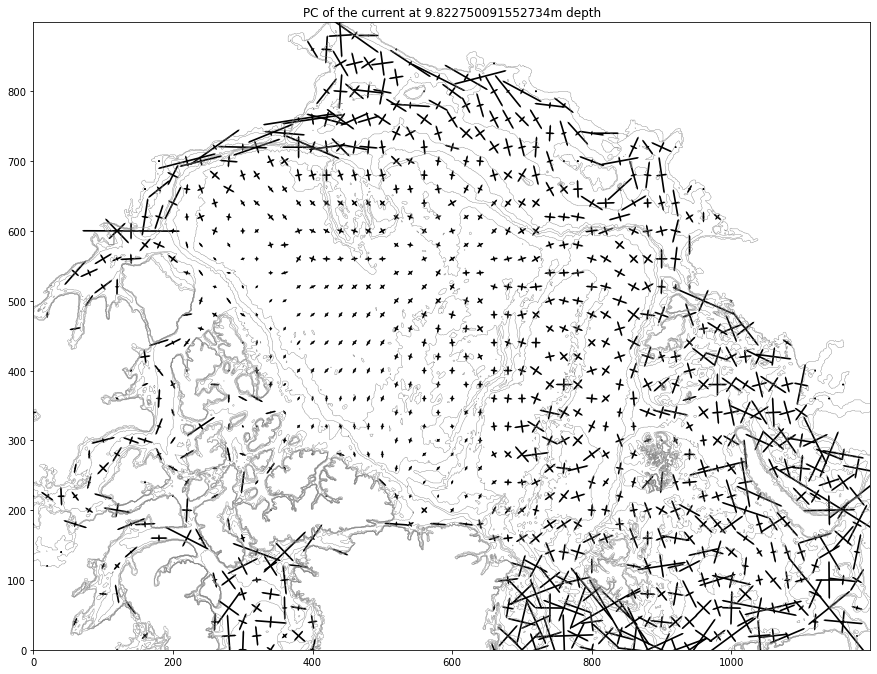

In [8]:
# Plot level 2
n = 1
PC11_s, PC12_s, PC21_s, PC22_s, x, y = PC_funk(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
ax.contour(ds.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::2], y[::2], PC11_s[::2], PC12_s[::2], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver(x[::2], y[::2], -PC11_s[::2], -PC12_s[::2],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::2], y[::2], PC21_s[::2], PC22_s[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::2], y[::2], -PC21_s[::2], -PC22_s[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.set_aspect('equal')
plt.show()

Figure of PC crosses at 10m depth. The variance in the middel of the basin have decreased from the surface. 

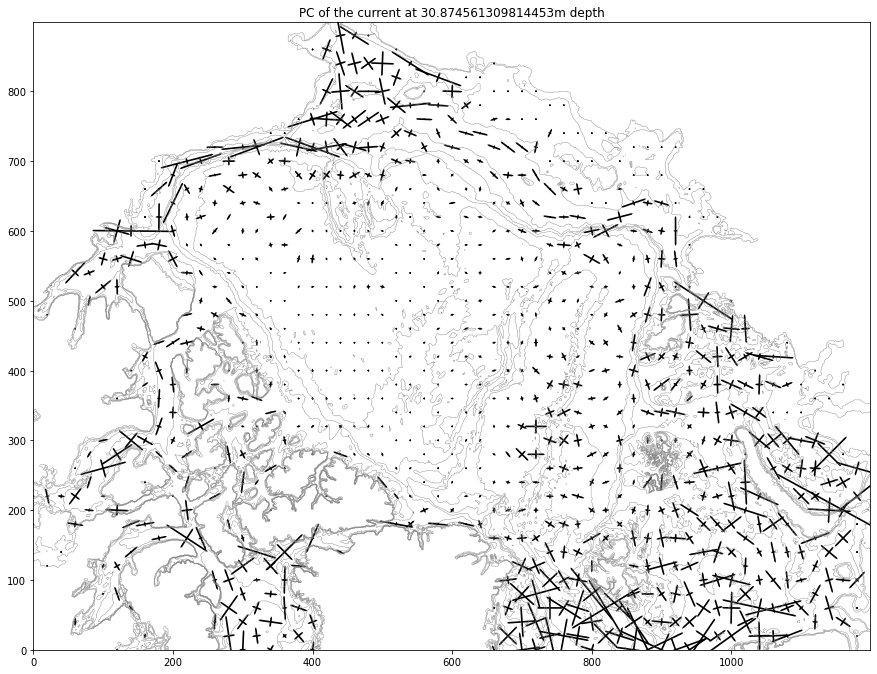

In [9]:
# Plot level 3
n = 2
PC11_s, PC12_s, PC21_s, PC22_s, x, y = PC_funk(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
ax.contour(ds.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::2], y[::2], PC11_s[::2], PC12_s[::2], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver(x[::2], y[::2], -PC11_s[::2], -PC12_s[::2],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::2], y[::2], PC21_s[::2], PC22_s[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::2], y[::2], -PC21_s[::2], -PC22_s[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.set_aspect('equal')
plt.show()

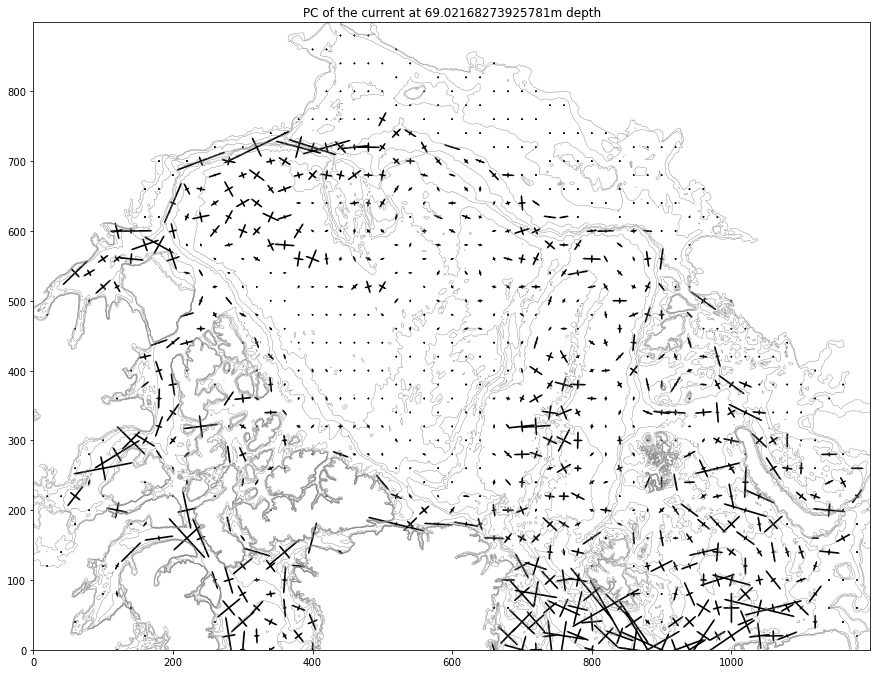

In [10]:
# Plot level 4
n = 3
PC11_s, PC12_s, PC21_s, PC22_s, x, y = PC_funk(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
ax.contour(ds.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::2], y[::2], PC11_s[::2], PC12_s[::2], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver(x[::2], y[::2], -PC11_s[::2], -PC12_s[::2],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::2], y[::2], PC21_s[::2], PC22_s[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::2], y[::2], -PC21_s[::2], -PC22_s[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.set_aspect('equal')
plt.show()

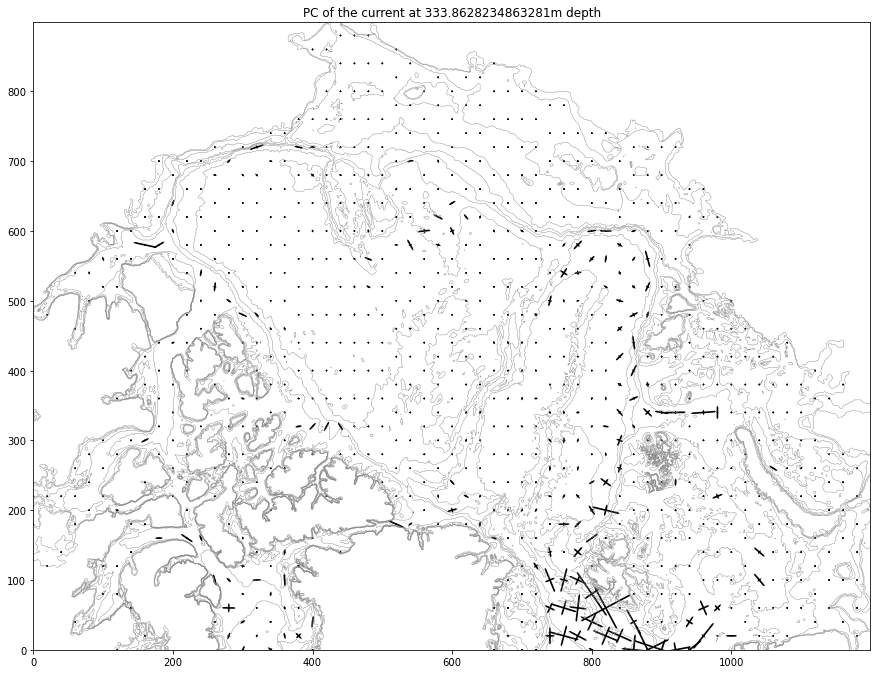

In [11]:
# Plot level 5
n = 4
PC11_s, PC12_s, PC21_s, PC22_s, x, y = PC_funk(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
ax.contour(ds.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::2], y[::2], PC11_s[::2], PC12_s[::2], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver(x[::2], y[::2], -PC11_s[::2], -PC12_s[::2],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::2], y[::2], PC21_s[::2], PC22_s[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::2], y[::2], -PC21_s[::2], -PC22_s[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.set_aspect('equal')
plt.show()

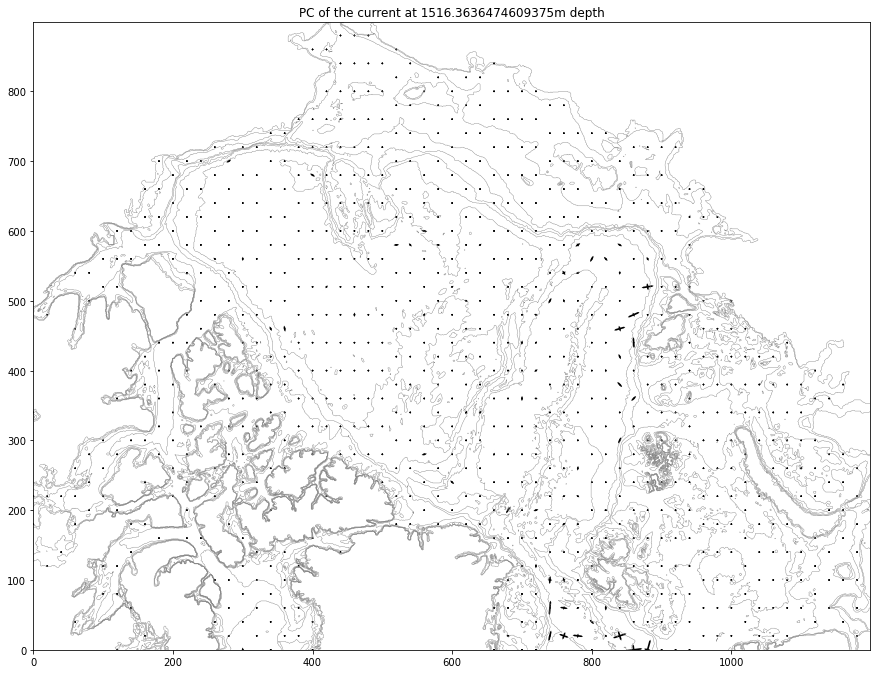

In [12]:
# Plot level 6
n = 5
PC11_s, PC12_s, PC21_s, PC22_s, x, y = PC_funk(level_list[n])

fig, ax = plt.subplots(1,1,figsize=(15,15))
plt.title(f'PC of the current at ' + str(depth_list[n]) + 'm depth')
ax.contour(ds.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)
ax.quiver( x[::2], y[::2], PC11_s[::2], PC12_s[::2], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver(x[::2], y[::2], -PC11_s[::2], -PC12_s[::2],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::2], y[::2], PC21_s[::2], PC22_s[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.quiver( x[::2], y[::2], -PC21_s[::2], -PC22_s[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=2)
ax.set_aspect('equal')
plt.show()